In [1]:
import numpy as np
import os
import torch
import torch.nn.functional as F
from typing import List, Optional, Tuple, Union
from transformers import PreTrainedModel, AutoModelForSequenceClassification, T5ForConditionalGeneration
from transformers import AutoTokenizer
import datasets

import math
from matplotlib import pyplot as plt


from typing import List, Optional, Tuple, Union
from transformers import BertForSequenceClassification
import transformers
from transformers.modeling_outputs import SequenceClassifierOutput

### Finetune

In [2]:
import sys
sys.path.append('..')
from transformers import AutoModelForSequenceClassification
from modeling_rmt import RMTEncoderForSequenceClassification
from torch.utils.data import DataLoader, Dataset, RandomSampler, SequentialSampler
# from modeling_rmt import RMTEncoderForSequenceClassification
# from modeling_rmt_enc_dec import RMTEncoderDecoderForConditionalGeneration

In [3]:
num_segments = 8
num_mem_tokens = 10
# device = torch.device(3)
device = 'cpu'

In [4]:
model_name = 'bert-base-cased'

tokenizer = AutoTokenizer.from_pretrained(model_name)

rmt_config = {'num_mem_tokens': num_mem_tokens, 
                'max_n_segments': num_segments,
                'tokenizer': tokenizer,
               #  'memory_layers': 'all', 
               #  'share_memory_layers': True,
                'reconstruction_loss_coef': 0.1,
                'segment_ordering': 'regular',
                'input_size': 512, 
                'bptt_depth': -1, 
                'sum_loss': False,
             }

base_model1 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
rmt1 = RMTEncoderForSequenceClassification(base_model1, **rmt_config)

base_model2 = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
rmt2 = RMTEncoderForSequenceClassification(base_model2, **rmt_config)

# base_model = AutoModelForSequenceClassification.from_pretrained(model_name, num_labels=6)
# rmt = RMTEncoderForSequenceClassification(base_model, **rmt_config)

# rmt = RMTEncoderMemoryLayers(base_model, **rmt_config)
# rmt = RMTEncoderMLMMemLoss(base_model, **rmt_config)
# rmt = RMTEncoderHorizontalMemory(base_model, **rmt_config)
# rmt.to(device)

/cephfs/home/bulatov/bulatov/hvdenv/lib/python3.8/site-packages/cryptography/hazmat/backends/openssl/x509.py:14: CryptographyDeprecationWarning: This version of cryptography contains a temporary pyOpenSSL fallback path. Upgrade pyOpenSSL now.
  warnings.warn(
Some weights of the model checkpoint at bert-base-cased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from 

In [5]:
cpt1 = torch.load('../../runs/curriculum_task/babilong/bert-base-cased/lr1e-05_linear_adamw_wd1e-03_1996-512-{4}seg_mem10_bs32_iters3000_regular_from_cpt_3-4/run_2/model_best.pth', map_location=device)
cpt2 = torch.load('../../runs/curriculum_task/babilong/bert-base-cased/lr1e-05_linear_adamw_wd1e-03_2994-512-{6}seg_mem10_bs32_iters3000_regular_from_cpt_5-6/run_2/model_best.pth', map_location=device)

In [6]:
rmt1.load_state_dict(cpt1['model_state_dict'])
rmt2.load_state_dict(cpt2['model_state_dict'])

<All keys matched successfully>

In [7]:
# out = rmt(sample_input_ids, **kwargs, output_hidden_states=False, output_attentions=False)
# out.keys()

### load dataset 

In [8]:
class Holder:
    def __init__(self):
        pass

In [9]:
input_seq_len = 3992
target_seq_len = 512
batch_size = 1

args = Holder
args.num_mem_tokens = 10
args.max_n_segments = 8
args.input_size = 512
args.target_seq_len = target_seq_len
args.input_seq_len = input_seq_len
args.input_prefix = ''
device = 'cpu'

In [10]:
from datasets import load_dataset
names = ['Mary', 'John', 'Daniel', 'Sandra']
actions = ['moved', 'went', 'went back', 'journeyed', 'travelled']
places = ['bathroom', 'hallway', 'garden', 'office', 'bedroom', 'kitchen']
choices_dict = {'names': names, 'actions': actions, 'places': places}

class MemoryDataset(Dataset):
    def __init__(self, choices_dict=choices_dict, num_facts=1, split='train', dataset='quality'):
        self.choices_dict = choices_dict
        self.dataset = load_dataset('tau/scrolls', dataset)[split]
        self.num_facts = num_facts

    def __getitem__(self, ind):
        sample = self.dataset[ind]
        sample['fact'], sample['question'], sample['answer'] = self.generate_qa() 
        return sample
    
    def __len__(self):
        return len(self.dataset)

    def generate_qa(self):
        names, actions, places = self.choices_dict['names'], self.choices_dict['actions'], self.choices_dict['places']

        np.random.shuffle(names)
        facts, questions, answers = [], [], []
        for fact_num, name in zip(range(self.num_facts), names):
            action, place = np.random.choice(actions), np.random.choice(places)

            facts.append(f'{name} {action} to the {place}')
            questions.append(f'Where is {name}?')
            answers.append(place)

        facts = ', '.join(facts) + '.'
        questions = ' '.join(questions)
        answers = ', '.join(answers)
        
        return facts, questions, answers

In [11]:

train_dataset = MemoryDataset(choices_dict, num_facts=1, split='train', dataset='quality')
valid_dataset = MemoryDataset(choices_dict, num_facts=1, split='validation', dataset='quality')

Reusing dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/quality/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

Reusing dataset scrolls (/home/bulatov/.cache/huggingface/datasets/tau___scrolls/quality/1.0.0/672021d5d8e1edff998a6ea7a5bff35fdfd0ae243e7cf6a8c88a57a04afb46ac)


  0%|          | 0/3 [00:00<?, ?it/s]

In [12]:
answers = train_dataset.choices_dict['places']
labels_map = dict(zip(answers, range(len(answers))))
num_labels = len(labels_map)
if args.num_mem_tokens is None:
    input_seg_size = args.input_size
else:
    input_seg_size = args.input_size - args.num_mem_tokens - tokenizer.num_special_tokens_to_add()
    if 'sep_token' in tokenizer.special_tokens_map:
        input_seg_size -= 1


### enc-dec

In [13]:
# raise NotImplementedError
global_attention_first_token = False  # should be True for LED
encode_plus_kwargs = {'truncation': True, 'padding': 'longest', 'pad_to_multiple_of': 1}
# generate_kwargs = {'max_length': args.target_seq_len, 'min_length': args.target_seq_len}
generate_kwargs = {}

def collate_fn(batch):
    # cut too long strings because they may slow down tokenization
    inputs = [b['fact'] + b['input'][:args.input_seq_len * 10] for b in batch]
    questions = [b['question'] for b in batch]
    labels = [b['answer'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]

    max_length = min(args.max_n_segments * input_seg_size, args.input_seq_len)
    features = tokenizer.batch_encode_plus(list(inputs), return_tensors='pt', **encode_plus_kwargs, max_length=max_length)
    questions = tokenizer.batch_encode_plus(list(questions), return_tensors='pt', **encode_plus_kwargs)['input_ids']

    with tokenizer.as_target_tokenizer():
        labels = tokenizer.batch_encode_plus(list(labels), max_length=args.target_seq_len, return_tensors='pt',
                                                **encode_plus_kwargs).input_ids
    labels[labels == tokenizer.pad_token_id] = -100
    features['labels'] = labels
    features['id'] = [b['id'] for b in batch]
    features['target_text'] = [b['answer'] for b in batch]
    if 'global_attention_mask' in features:
        raise RuntimeError('What global attention mask for Longformer and LongformerEncoder-Decoder should be?')
    return features


### enc

In [14]:
encode_plus_kwargs = {
                    #   'max_length': args.input_seq_len,
                        'truncation': True,
                        'padding': 'longest',
                        'pad_to_multiple_of': 1}
generate_kwargs = {}

def collate_fn(batch, input_seg_size=input_seg_size):
    # cut too long strings because they may slow down tokenization
    # inputs = ['[memorize] ' + b['fact'] + ' [/memorize] ' + b['input'][:args.input_seq_len * 10] for b in batch]
    inputs = [b['fact'] + b['input'][:args.input_seq_len * 10] for b in batch]
    questions = [b['question'] for b in batch]
    labels = [b['answer'][:args.target_seq_len * 10] for b in batch]
    if args.input_prefix:
        inputs = [args.input_prefix + inp for inp in inputs]

    max_length = min(args.max_n_segments * input_seg_size, args.input_seq_len)
    features = tokenizer.batch_encode_plus(list(inputs), return_tensors='pt', **encode_plus_kwargs, max_length=max_length)
    questions = tokenizer.batch_encode_plus(list(questions), return_tensors='pt', **encode_plus_kwargs)['input_ids']
    
    q_len = questions.shape[1] - 1
    features['input_ids'] = torch.cat([features['input_ids'][:, :max_length - q_len], questions[:, 1:]], dim=1)
    
    labels = np.array([labels_map[t] for t in labels])
    features['labels'] = torch.from_numpy(labels)
    return features

In [15]:
# train_sampler = DistributedSampler(train_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=True,
#                                        drop_last=False, seed=args.seed)
# per_worker_batch_size = args.batch_size * args.gradient_accumulation_steps
# global_batch_size = per_worker_batch_size * hvd.size()
kwargs = {'pin_memory': True, 'num_workers': 1}
train_dataloader = DataLoader(train_dataset, batch_size=batch_size,# sampler=train_sampler,
                                collate_fn=collate_fn, **kwargs)
# # get validation dataset
# valid_dataloader = None
# if hvd.rank() == 0:
#     logger.info(f'preparing validation data from babilong')
# # if args.task_name in tasks_with_duplicates:
# #     valid_dataset = drop_duplicates_in_input(valid_dataset)
# valid_sampler = DistributedSampler(valid_dataset, rank=hvd.rank(), num_replicas=hvd.size(), shuffle=False)
# valid_dataloader = DataLoader(valid_dataset, batch_size=per_worker_batch_size, sampler=valid_sampler,
#                                 collate_fn=collate_fn, **kwargs)

In [16]:
gen = iter(train_dataloader)
batch = next(gen)


In [17]:
input_ids = batch.pop('input_ids')
out1 = rmt1(input_ids, **batch, output_attentions = True)
out2 = rmt2(input_ids, **batch, output_attentions = True)

In [18]:
out1['loss'], out2['loss']

(tensor(0.0409, grad_fn=<NllLossBackward>),
 tensor(0.0018, grad_fn=<NllLossBackward>))

In [19]:
segmented = rmt1.pad_and_segment(input_ids)

In [20]:
len(segmented)

8

### numeric comparison

### какая масса Attention приходится на память?

In [27]:
layer = -1
segment = 3
bn = 0
head = 0
tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]

memory_inds = range(1, 11)
cls_inds = [0]
mem_inds = np.where(np.array(tokens) == '')[0]
sep_inds = np.where(np.array(tokens) == '[SEP]')[0]
seg_inds = list(map(lambda x: x not in {'[SEP]', '[CLS]', '[PAD]', ''}, tokens))
# attentions1[0].sum(dim=1)

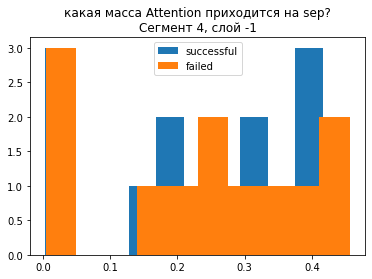

In [29]:
# какая масса Attention приходится на sep_inds?
layer = -1
segment = 3
bn = 0
head = 0

attentions1 = out1[f'attentions_{segment}'][layer][bn]
attentions2 = out2[f'attentions_{segment}'][layer][bn]
plt.title(f'какая масса Attention приходится на sep?\nСегмент {segment+1}, слой {layer}')
plt.hist(attentions1[:, :, sep_inds].sum(dim=2).mean(dim=1).detach())
plt.hist(attentions2[:, :, sep_inds].sum(dim=2).mean(dim=1).detach())
plt.legend(['successful', 'failed'])
plt.show()

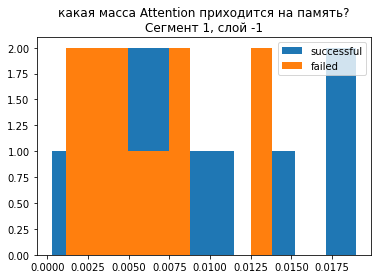

In [25]:
# какая масса Attention приходится на память?
layer = -1
segment = 0
bn = 0
head = 0

attentions1 = out1[f'attentions_{segment}'][layer][bn]
attentions2 = out2[f'attentions_{segment}'][layer][bn]
plt.title(f'какая масса Attention приходится на память?\nСегмент {segment+1}, слой {layer}')
plt.hist(attentions1[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.hist(attentions2[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.legend(['successful', 'failed'])
plt.show()

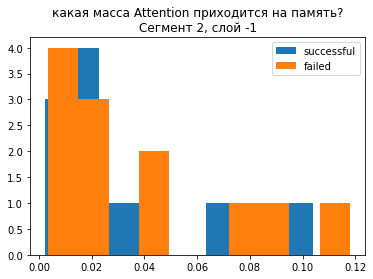

In [26]:
layer = -1
segment = 1
bn = 0
head = 0

attentions1 = out1[f'attentions_{segment}'][layer][bn]
attentions2 = out2[f'attentions_{segment}'][layer][bn]
plt.title(f'какая масса Attention приходится на память?\nСегмент {segment+1}, слой {layer}')
plt.hist(attentions1[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.hist(attentions2[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.legend(['successful', 'failed'])
plt.show()

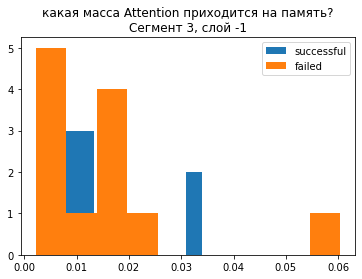

In [172]:
layer = -1
segment = 2
bn = 0
head = 0

attentions1 = out1[f'attentions_{segment}'][layer][bn]
attentions2 = out2[f'attentions_{segment}'][layer][bn]
plt.title(f'какая масса Attention приходится на память?\nСегмент {segment+1}, слой {layer}')
plt.hist(attentions1[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.hist(attentions2[:, :, mem_inds].sum(dim=2).mean(dim=1).detach())
plt.legend(['successful', 'failed'])
plt.show()

### losses

In [30]:
np.array(tokens)[mem_inds]

array(['', '', '', '', '', '', '', '', '', ''], dtype='<U12')

In [31]:
attentions1.shape

torch.Size([12, 512, 512])

Text(0, 0.5, 'loss')

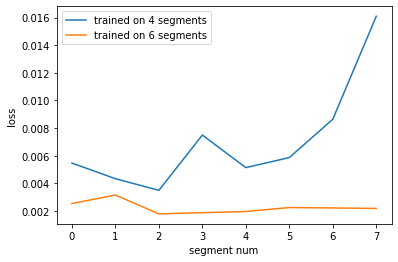

In [37]:
plt.plot([out1[f'loss_{i}'] for i in range(8)])
plt.plot([out2[f'loss_{i}'] for i in range(8)])
plt.legend(['trained on 4 segments', 'trained on 6 segments'])
plt.xlabel('segment num')
plt.ylabel('loss')

In [32]:
out1['loss_0'].item(), out1['loss_1'].item(), out1['loss_2'].item()

(0.005470188334584236, 0.004339089151471853, 0.003495180746540427)

In [120]:
out2['loss_0'].item(), out2['loss_1'].item(), out2['loss_2'].item()

(1.9188117980957031, 1.9174211025238037, 1.8703436851501465)

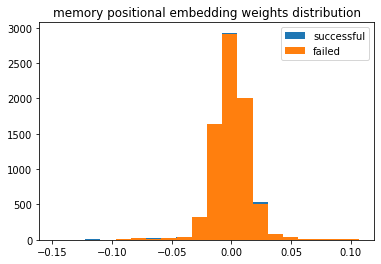

In [177]:
## embedding weights
memory_embeddings1 = rmt1.model.base_model.embeddings.position_embeddings.weight[1:11]
memory_embeddings2 = rmt2.model.base_model.embeddings.position_embeddings.weight[1:11]

plt.title('memory positional embedding weights distribution')
plt.hist(memory_embeddings1.flatten().detach(), bins=20)
plt.hist(memory_embeddings2.flatten().detach(), bins=20)

plt.legend(['successful', 'failed'])
plt.show()

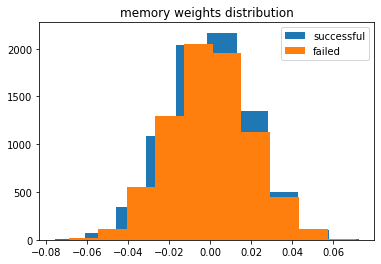

In [74]:
## memory weights
memory1 = rmt1.set_memory((1, 512))
memory2 = rmt2.set_memory((1, 512))

plt.title('memory weights distribution')
plt.hist(memory1.flatten().detach())
plt.hist(memory2.flatten().detach())

plt.legend(['successful', 'failed'])
plt.show()

### plot attentions


In [21]:
from matplotlib import pyplot as plt
%matplotlib inline

import numpy as np

def plot_attention_weights(attentions, tokens, y_tokens=None, p_attentions=None, filename='att.png', save=False, size=None):
    # attentions n_layers x n_heads x len x len
    attention = attentions.detach()
    if size is not None:
        sz = size
    else:
        sz = max(*attention.shape) // 3
    fig = plt.figure(figsize=(sz, sz))
    if y_tokens is None:
        y_tokens = tokens
        fig = plt.figure(figsize=(sz, 3*sz))
    y_tokens = y_tokens[:attention.shape[1]]
    tokens = tokens[:attention.shape[2]]    

    
    # if p_attentions:
    #     p_attention = p_attentions[layer]

    for head in range(attention.shape[0]):
        ax = fig.add_subplot(6, 2, head+1)

        # plot the attention weights
        if p_attentions:
            att = np.concatenate([np.expand_dims(p_attention[head], axis=0), attention[head]], axis=0)
            ax.matshow(att[:len(y_tokens)+1,:len(tokens)], cmap='Reds')
        else:
            ax.matshow(attention[head][:len(y_tokens),:len(tokens)], cmap='Reds')

        fontdict = {'fontsize': 10}

        ax.set_xticks(range(len(tokens)))
        if p_attentions:
            ax.set_yticks(range(len(y_tokens) + 1))
            ax.set_yticklabels(['[P]'] + y_tokens, fontdict)
        else:
            ax.set_yticks(range(len(y_tokens)))
            # print('y_tokens', len(y_tokens), y_tokens)
            ax.set_yticklabels(y_tokens)#, fontdict)

        ax.set_xticklabels(tokens,fontdict=fontdict, rotation=90)

        ax.set_xlabel('Head {}'.format(head+1), fontdict)

    plt.tight_layout()
    if save:
        plt.savefig(filename)
    plt.show()

In [22]:
# segmented = rmt.pad_and_segment(input_ids)

### seg 0: rite to memory

seg0-l5-h1: 0.5406230688095093


<Figure size 720x720 with 0 Axes>

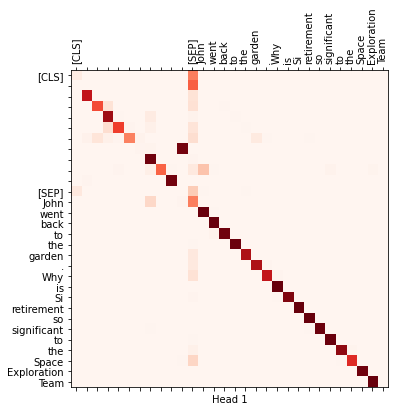

<Figure size 720x720 with 0 Axes>

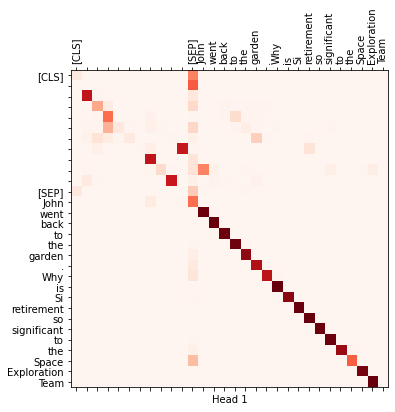

seg0-l6-h9: 0.7162611484527588


<Figure size 720x720 with 0 Axes>

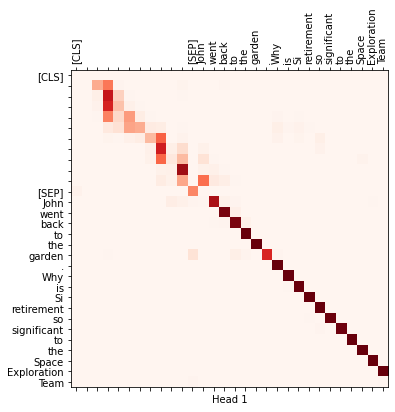

<Figure size 720x720 with 0 Axes>

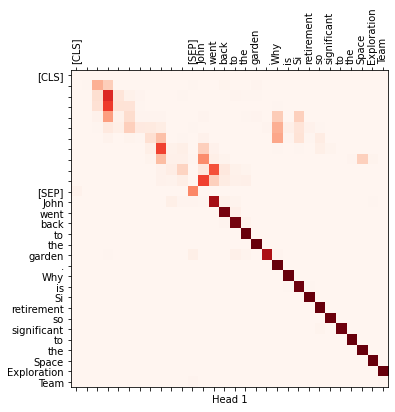

In [38]:
segment = 0
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30

max_diff_thr = 0.5

attentions1 = out1[f'attentions_{segment}']
attentions2 = out2[f'attentions_{segment}']

for layer, (layer_attn1, layer_attn2) in enumerate(zip(attentions1, attentions2)):
    for head, (head_attn1, head_attn2) in enumerate(zip(layer_attn1[bn], layer_attn2[bn])):
        diff = (head_attn1[min_y:max_y, min_x:max_x] - head_attn2[min_y:max_y, min_x:max_x]).max().item()
        if diff > max_diff_thr:
            print(f'seg{segment}-l{layer}-h{head}:', diff)
            fn = f'img/rmt5_attn_seg0_l{layer}.png'
            tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
            plot_attention_weights(attentions1[layer][bn][head:head+1][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)
            plot_attention_weights(attentions2[layer][bn][head:head+1][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

seg0-l5-h1: 0.5406230688095093
difference


<Figure size 720x720 with 0 Axes>

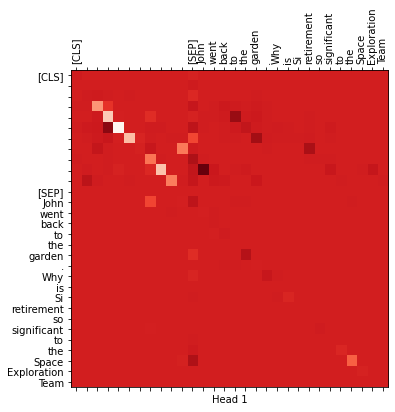

seg0-l6-h9: 0.7162611484527588
difference


<Figure size 720x720 with 0 Axes>

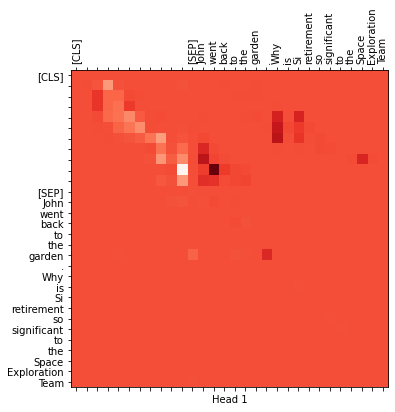

seg0-l9-h0: 0.33024150133132935
difference


<Figure size 720x720 with 0 Axes>

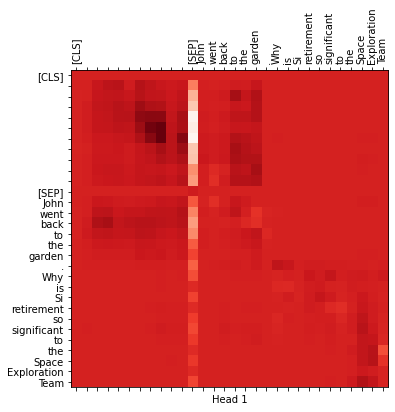

seg0-l9-h1: 0.3554258644580841
difference


<Figure size 720x720 with 0 Axes>

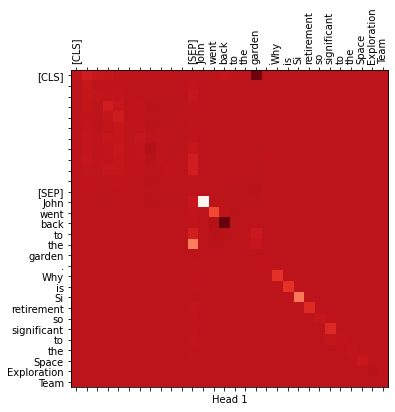

seg0-l10-h8: 0.3154871165752411
difference


<Figure size 720x720 with 0 Axes>

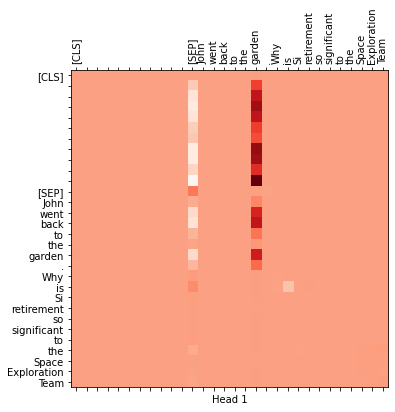

seg0-l11-h2: 0.4200558662414551
difference


<Figure size 720x720 with 0 Axes>

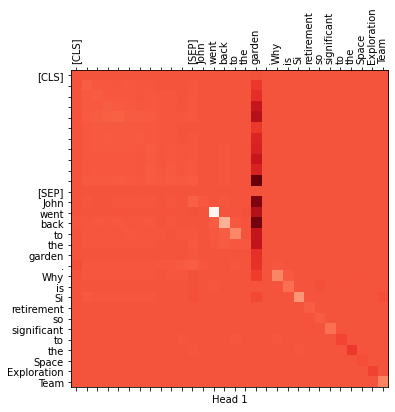

seg0-l11-h3: 0.49890589714050293
difference


<Figure size 720x720 with 0 Axes>

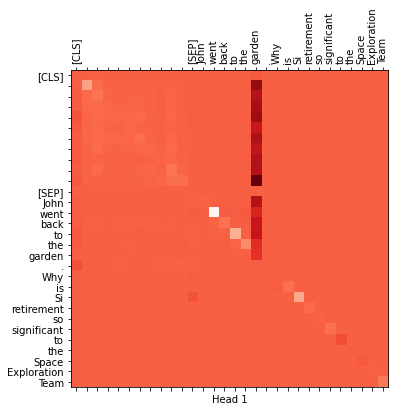

seg0-l11-h11: 0.39405250549316406
difference


<Figure size 720x720 with 0 Axes>

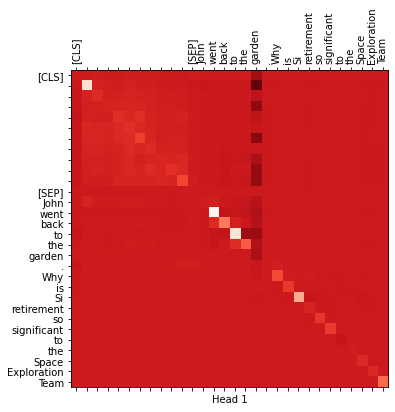

seg1-l1-h11: 0.4364359676837921
difference


<Figure size 720x720 with 0 Axes>

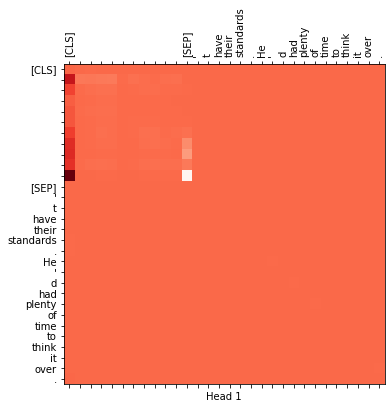

seg1-l7-h1: 0.331083208322525
difference


<Figure size 720x720 with 0 Axes>

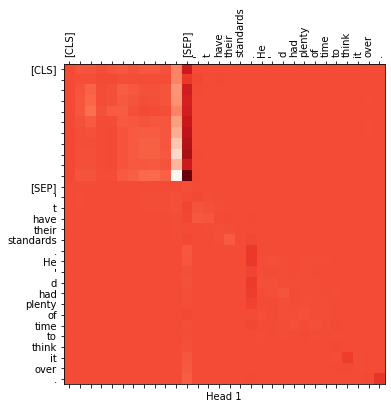

seg2-l10-h2: 0.3610888421535492
difference


<Figure size 720x720 with 0 Axes>

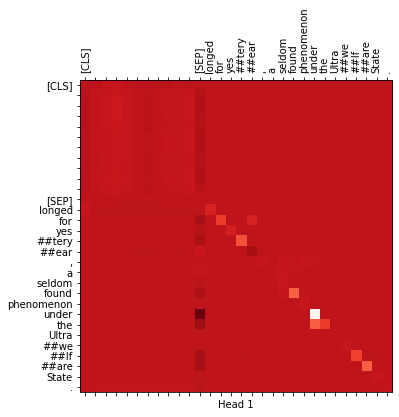

seg2-l11-h2: 0.3161008059978485
difference


<Figure size 720x720 with 0 Axes>

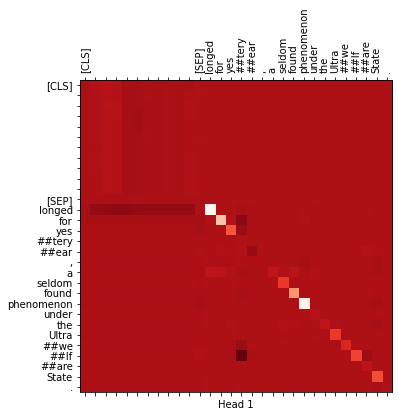

seg3-l7-h4: 0.32328081130981445
difference


<Figure size 720x720 with 0 Axes>

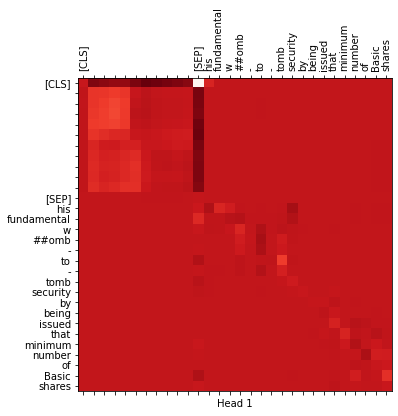

seg3-l11-h2: 0.3358122408390045
difference


<Figure size 720x720 with 0 Axes>

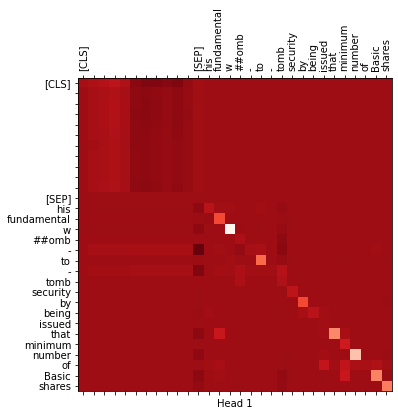

seg4-l7-h4: 0.3188260495662689
difference


<Figure size 720x720 with 0 Axes>

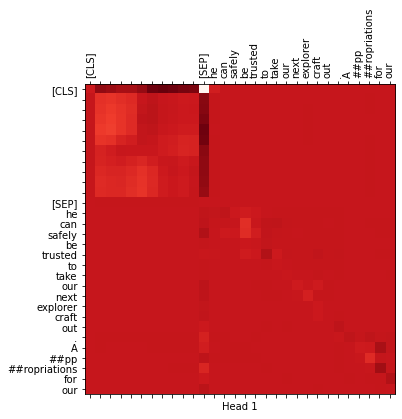

seg5-l7-h4: 0.43990957736968994
difference


<Figure size 720x720 with 0 Axes>

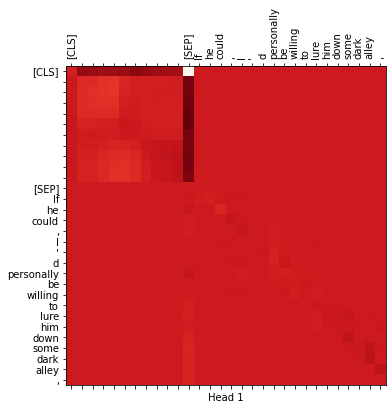

seg5-l10-h6: 0.34870490431785583
difference


<Figure size 720x720 with 0 Axes>

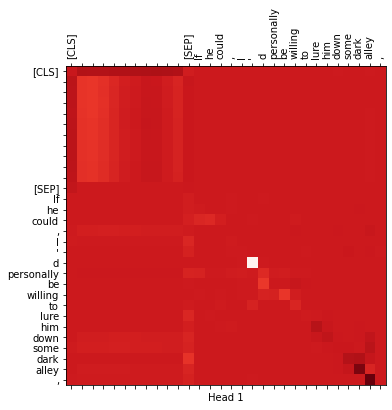

seg6-l7-h3: 0.323588490486145
difference


<Figure size 720x720 with 0 Axes>

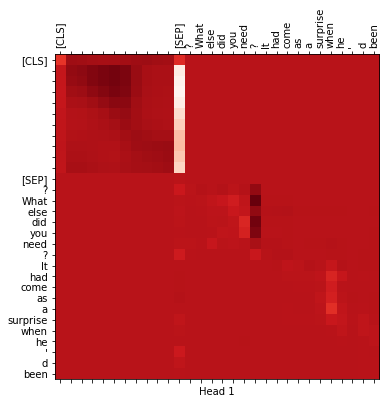

seg6-l7-h4: 0.43808862566947937
difference


<Figure size 720x720 with 0 Axes>

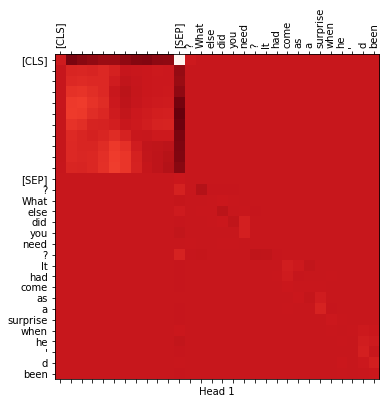

seg7-l7-h3: 0.33715760707855225
difference


<Figure size 720x720 with 0 Axes>

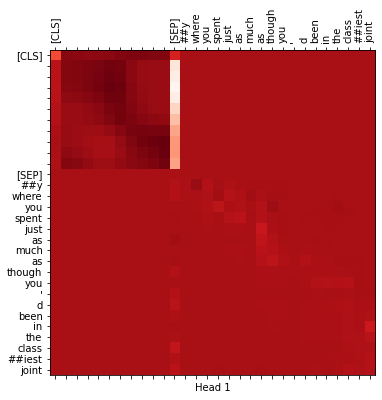

seg7-l7-h4: 0.43576741218566895
difference


<Figure size 720x720 with 0 Axes>

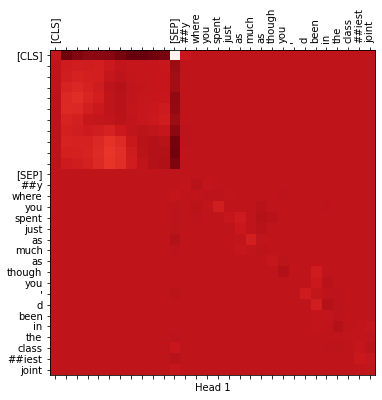

In [44]:
for segment in range(8):
    bn = 0

    min_x, max_x = 0, 30
    min_y, max_y = 0, 30

    max_diff_thr = 0.3

    attentions1 = out1[f'attentions_{segment}']
    attentions2 = out2[f'attentions_{segment}']

    for layer, (layer_attn1, layer_attn2) in enumerate(zip(attentions1, attentions2)):
        for head, (head_attn1, head_attn2) in enumerate(zip(layer_attn1[bn], layer_attn2[bn])):
            diff = (head_attn1[min_y:max_y, min_x:max_x] - head_attn2[min_y:max_y, min_x:max_x]).max().item()
            if diff > max_diff_thr:
                print(f'seg{segment}-l{layer}-h{head}:', diff)
                fn = f'img/rmt5_attn_seg0_l{layer}.png'
                tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
                # print('4-seg')
                # plot_attention_weights(attentions1[layer][bn][head:head+1][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)
                # print('6-seg')
                # plot_attention_weights(attentions2[layer][bn][head:head+1][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)
                print('difference')
                plot_attention_weights(attentions2[layer][bn][head:head+1][:, min_y:max_y, min_x:max_x] - attentions1[layer][bn][head:head+1][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

In [27]:
layer_attn1.shape

torch.Size([1, 12, 512, 512])

<Figure size 720x720 with 0 Axes>

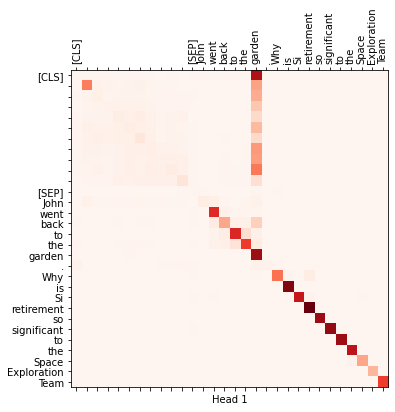

<Figure size 720x720 with 0 Axes>

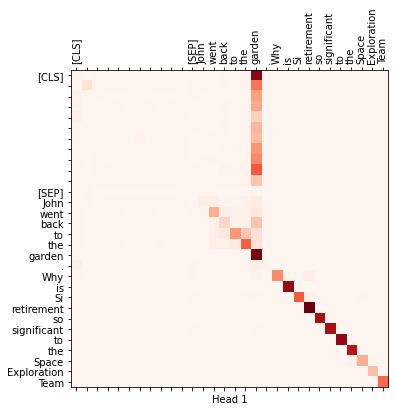

In [36]:
fn = f'img/rmt5_attn_seg0_l{layer}.png'
tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
plot_attention_weights(attentions1[layer][bn][head:head+1][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)
plot_attention_weights(attentions2[layer][bn][head:head+1][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

<Figure size 720x720 with 0 Axes>

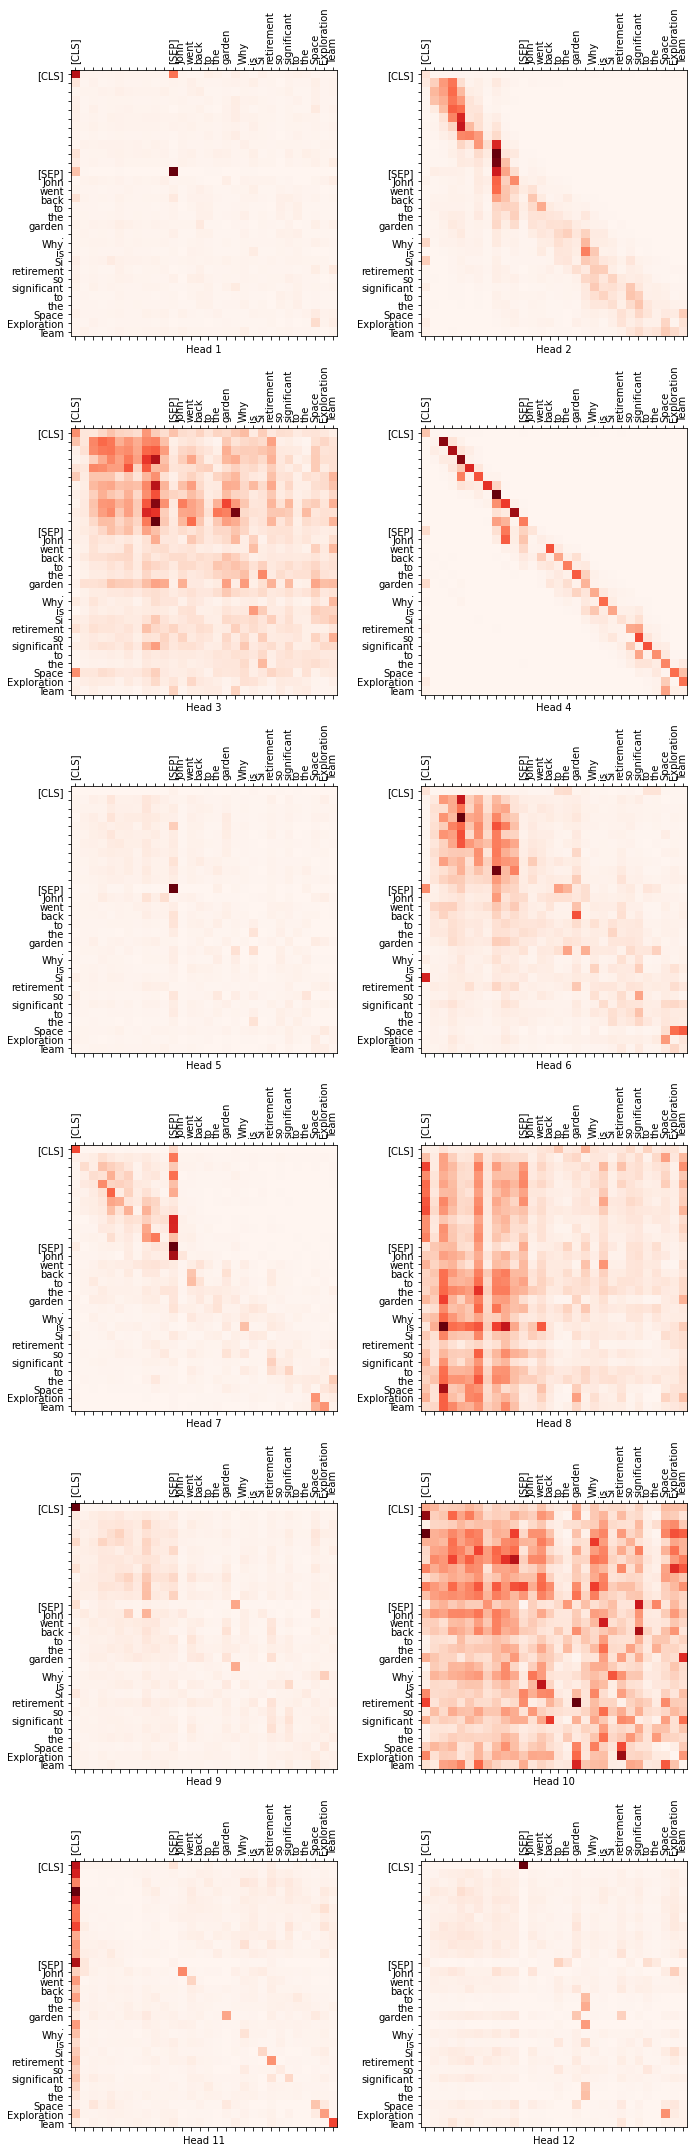

In [23]:
# 4-seg
layer = 0
segment = 0
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out1[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

<Figure size 720x720 with 0 Axes>

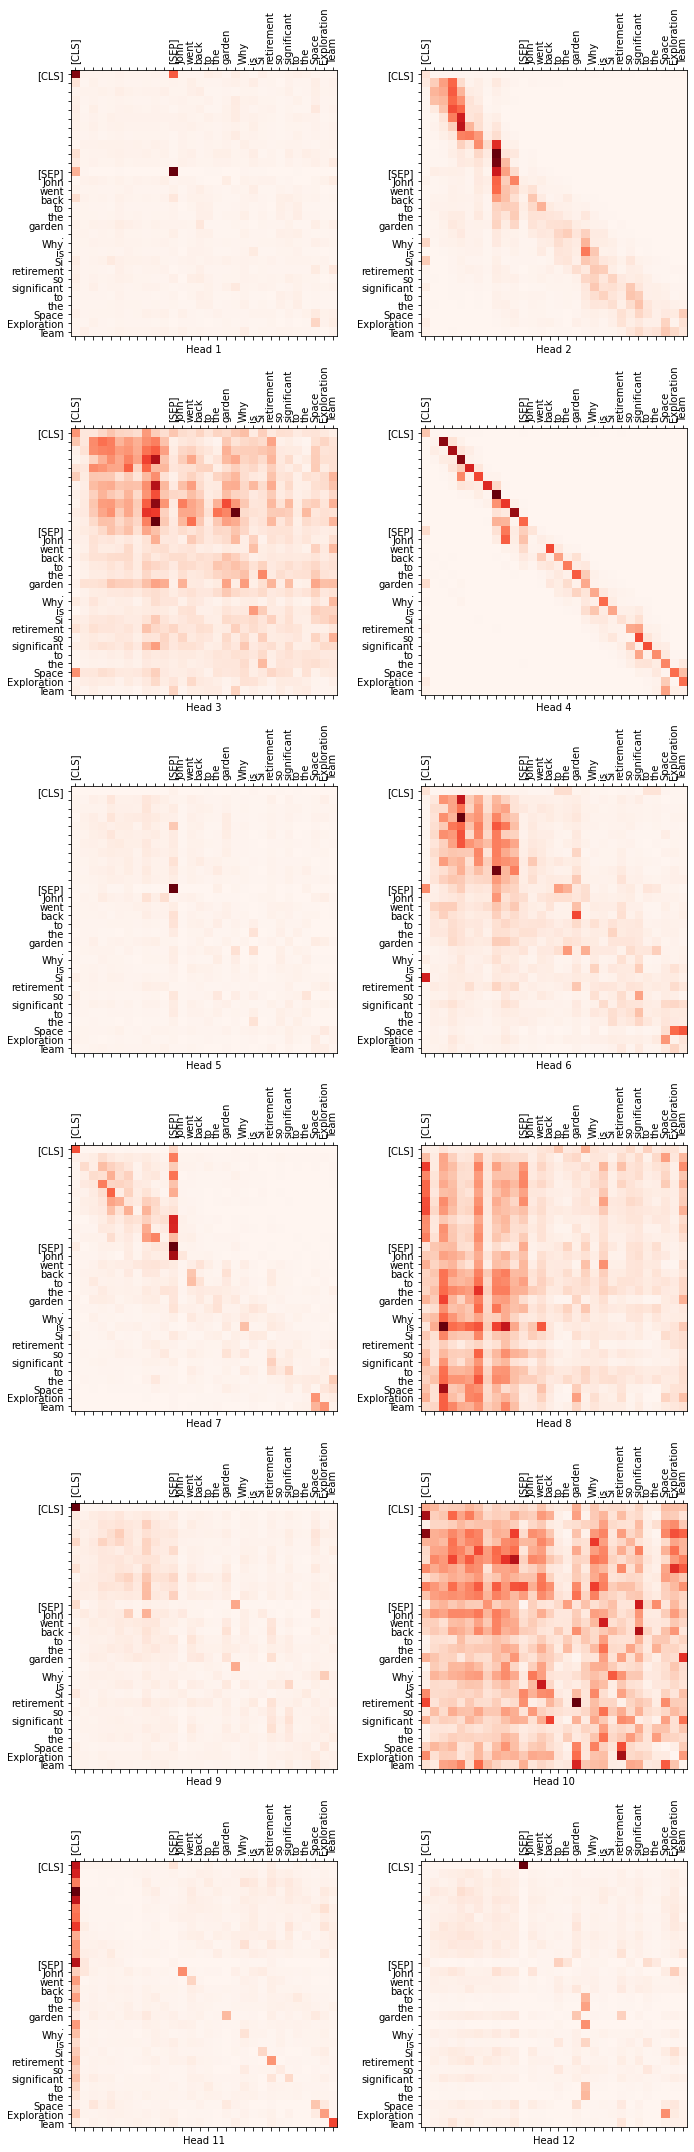

In [24]:
# 6-seg
layer = 0
segment = 0
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out2[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

## 4seg

<Figure size 720x720 with 0 Axes>

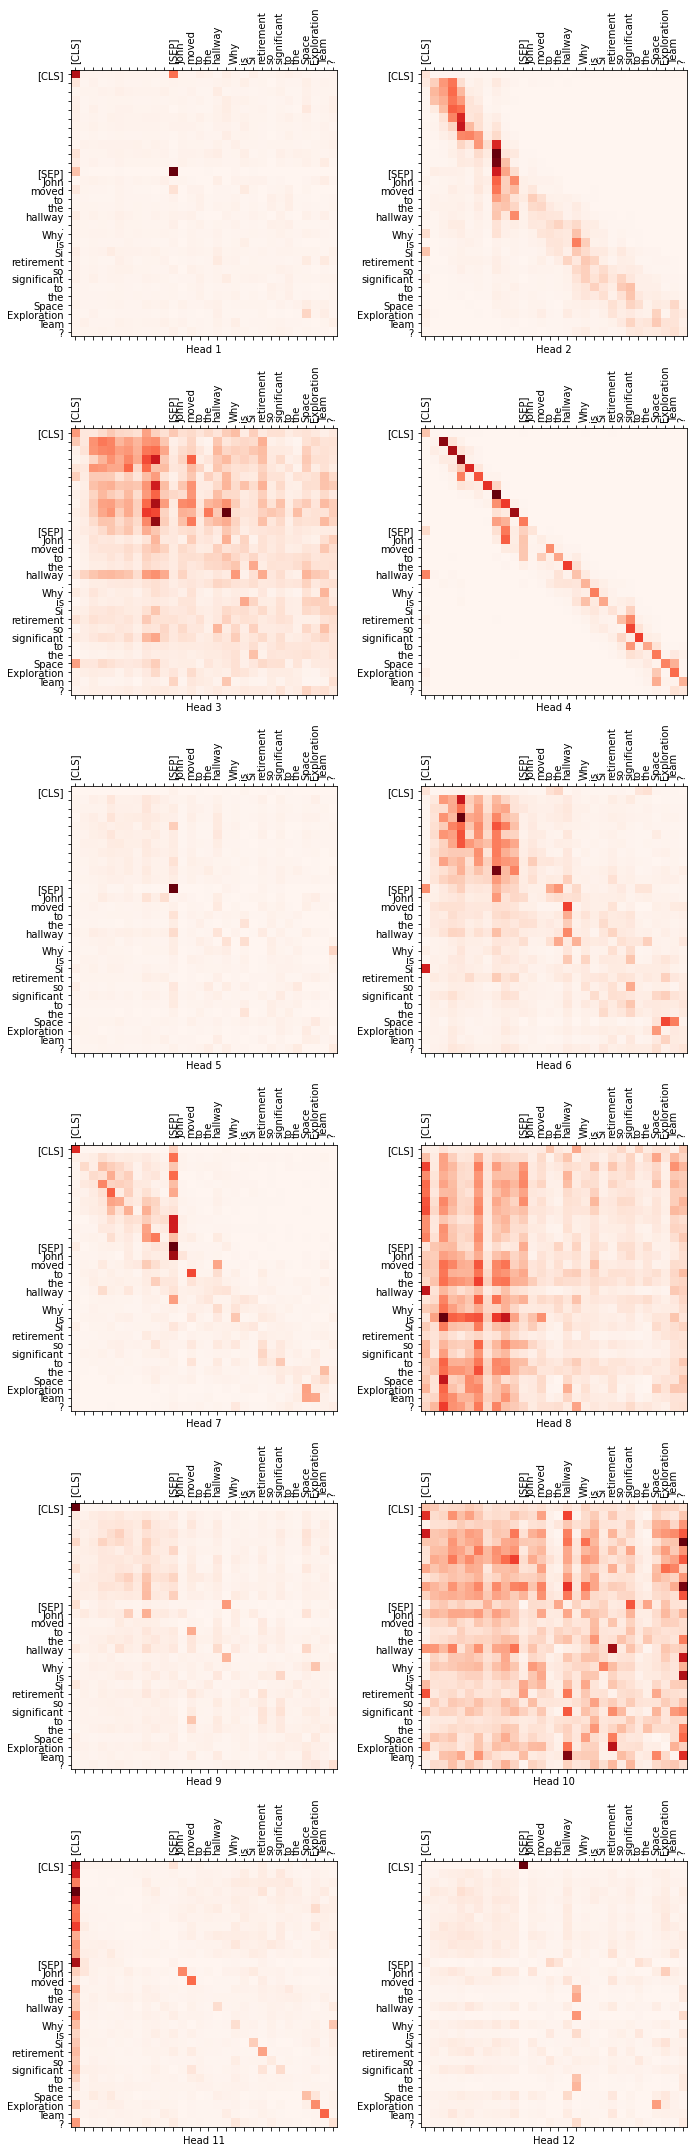

In [55]:
# seg 1
layer = 0
segment = 0
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out1[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

<Figure size 720x720 with 0 Axes>

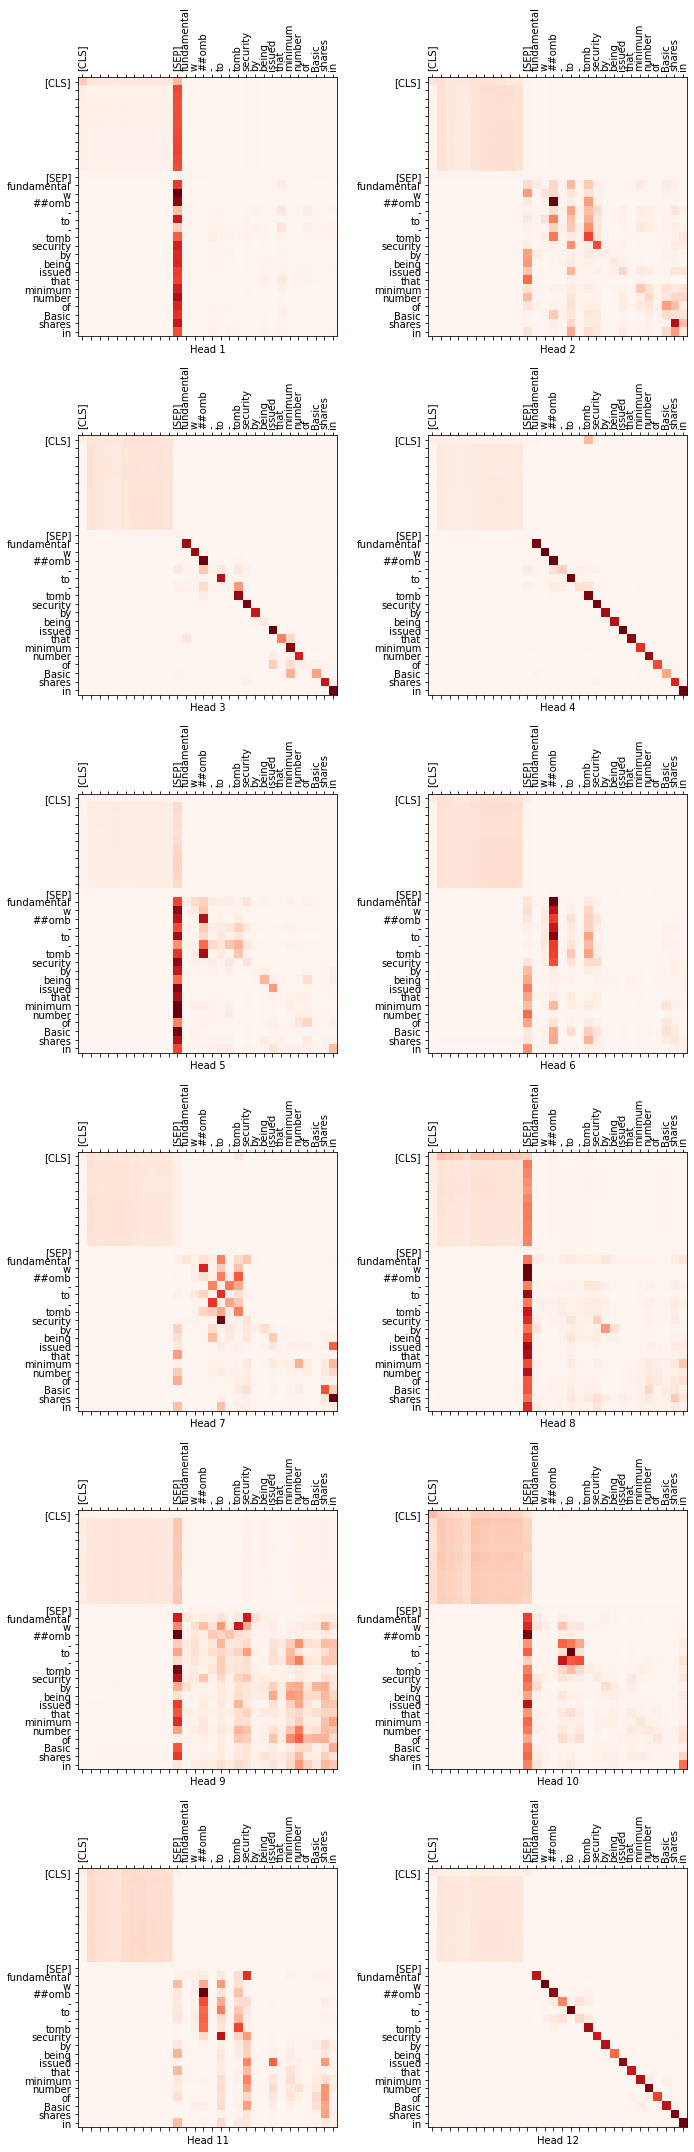

In [42]:
# seg 2
layer = -1
segment = 3
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out1[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

<Figure size 720x720 with 0 Axes>

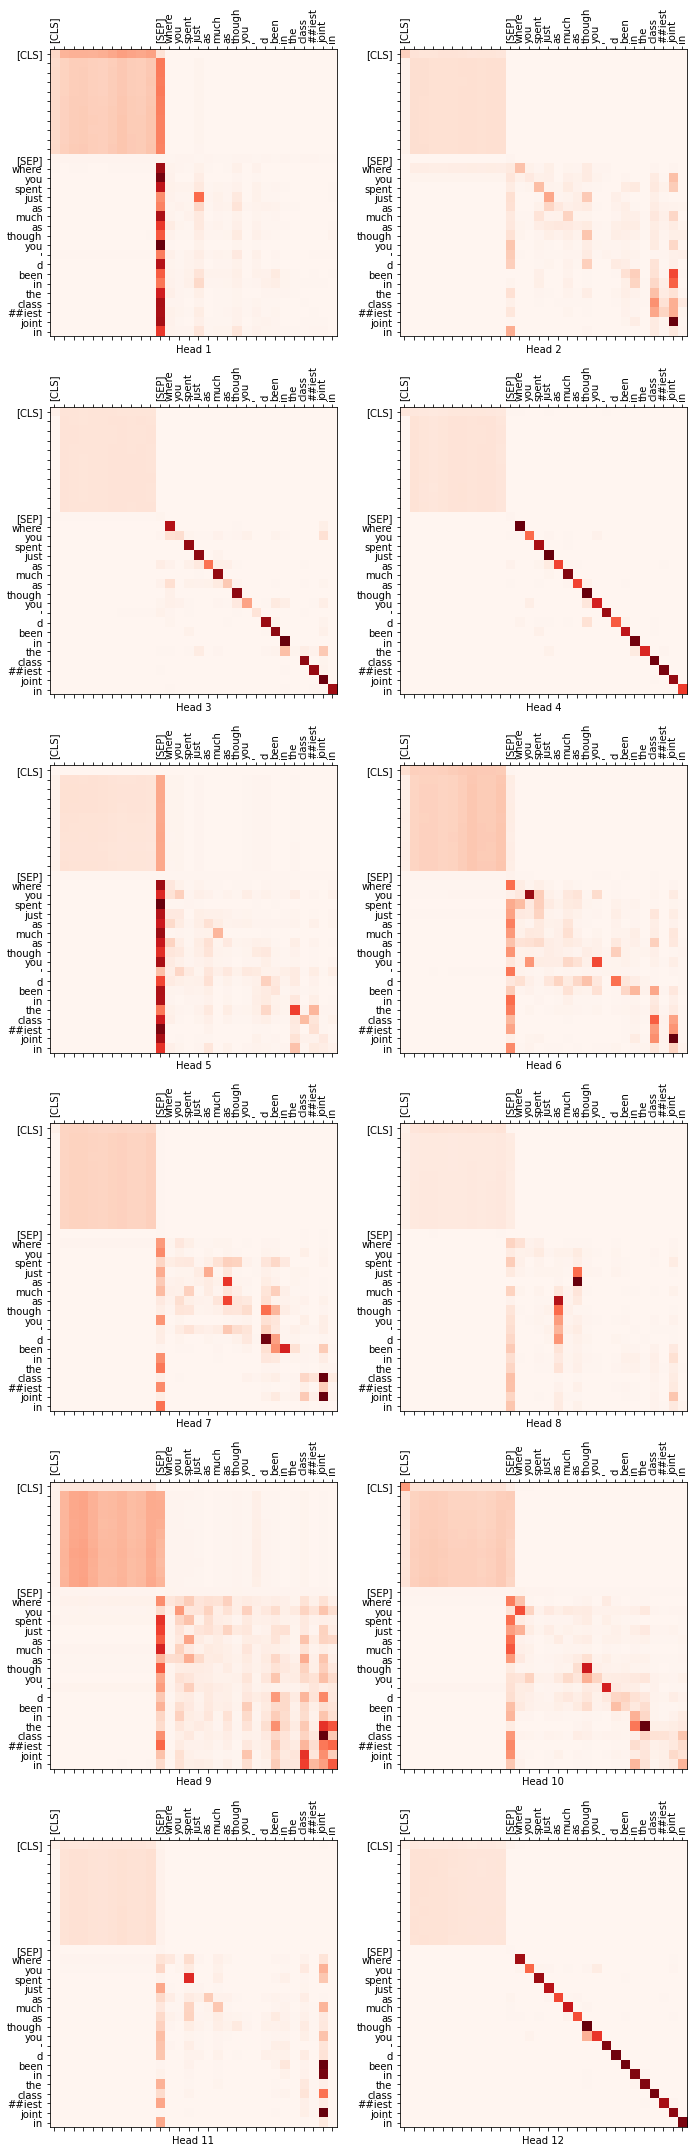

In [44]:
# seg 3
layer = -1
segment = 7
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out1[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

## 6 seg

### seg1

In [80]:
len(attentions), attentions[0].shape

(12, torch.Size([2, 12, 180, 180]))

In [44]:
head = 0
attentions[layer][bn][head]

torch.Size([12, 180, 180])

<Figure size 720x720 with 0 Axes>

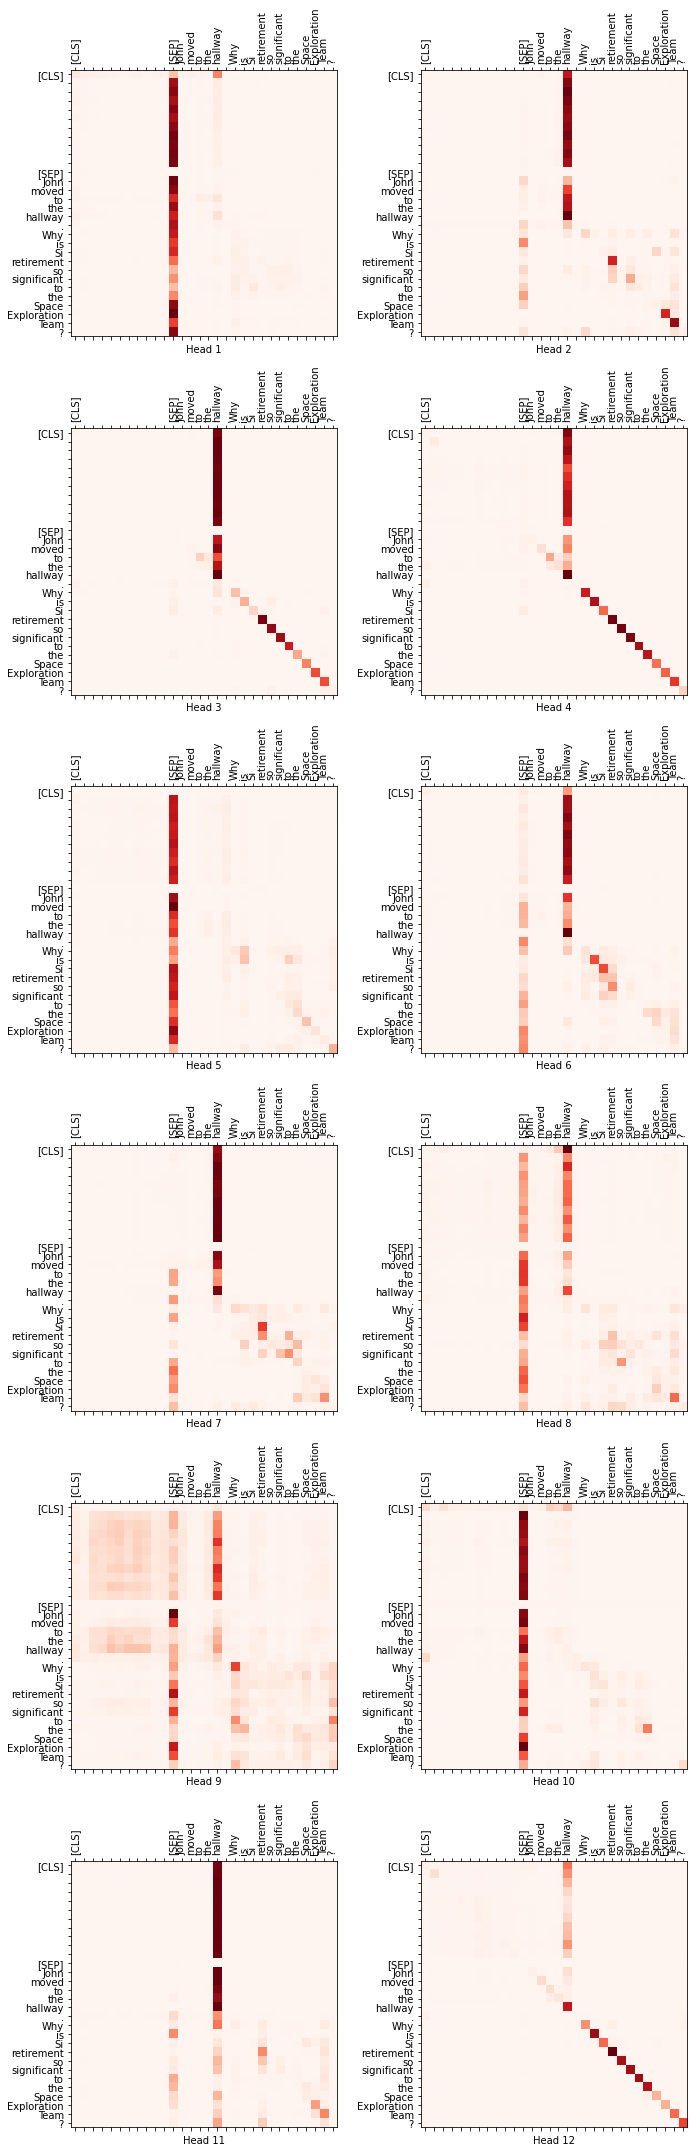

In [45]:
layer = -1
segment = 0
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out2[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

### seg2

<Figure size 720x720 with 0 Axes>

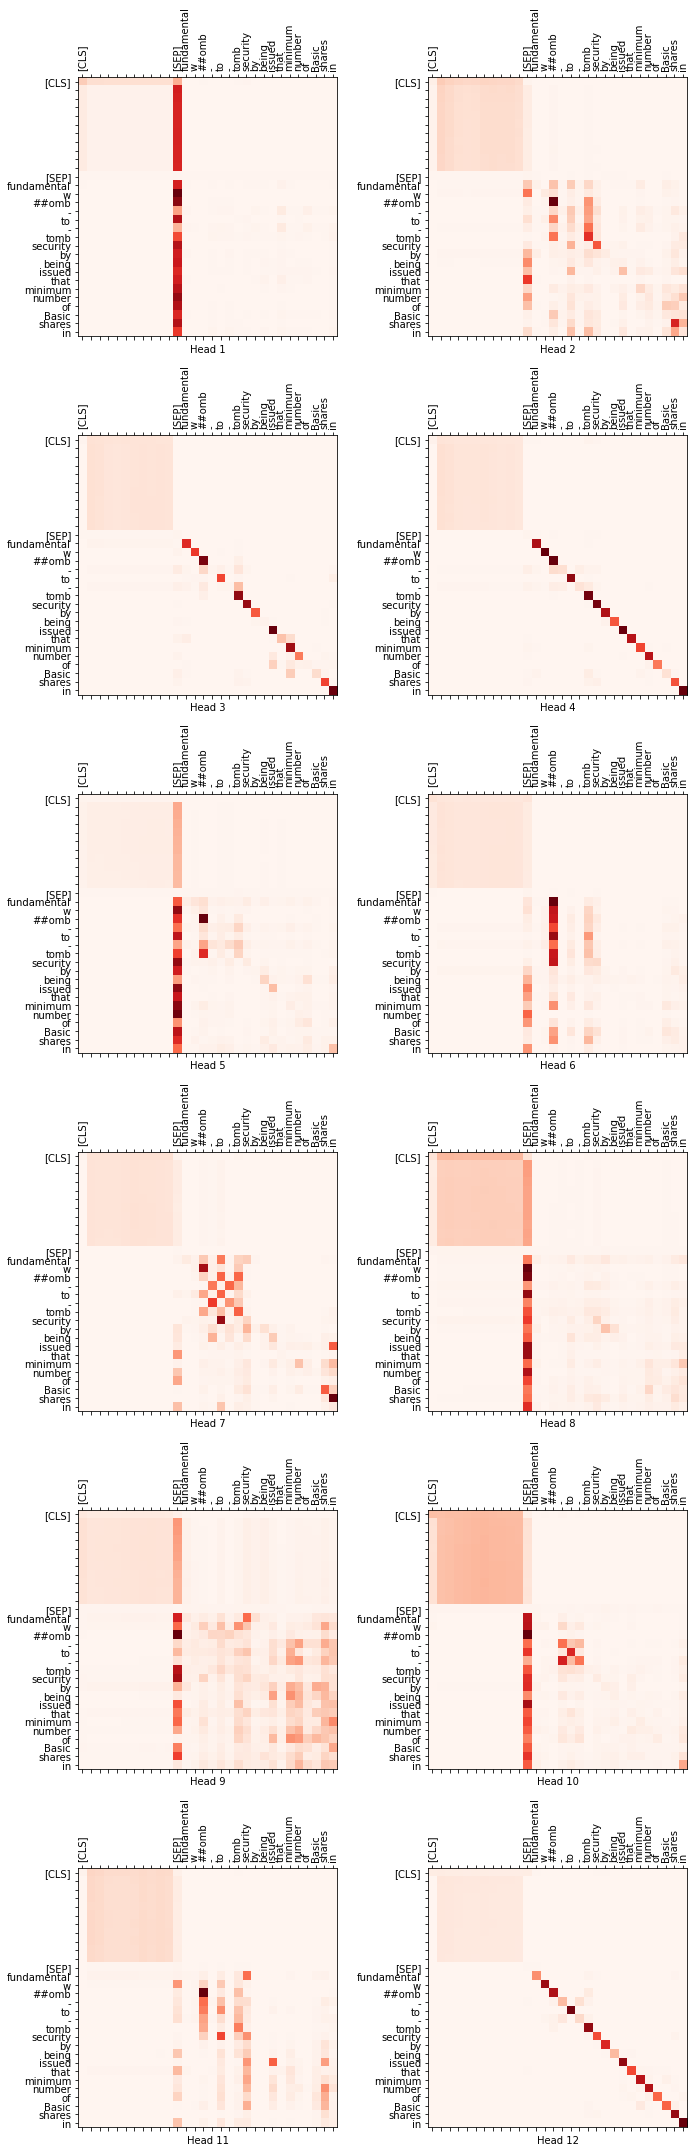

In [52]:
layer = -1
segment = 3
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out2[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)

### seg3

<Figure size 720x720 with 0 Axes>

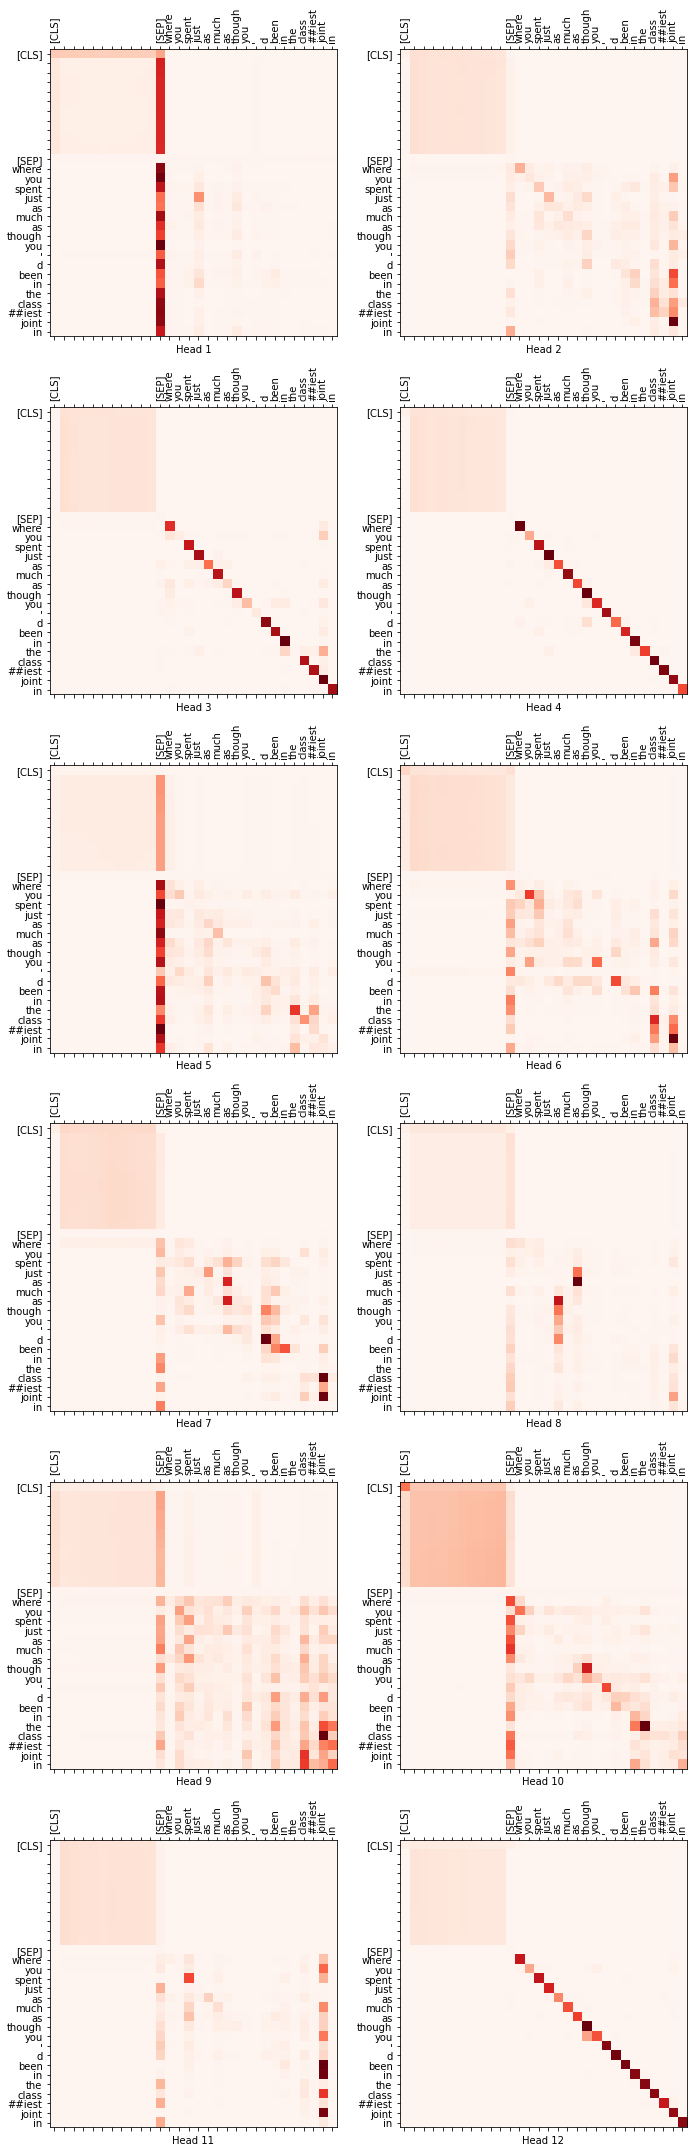

In [54]:
layer = -1
segment = 7
bn = 0

min_x, max_x = 0, 30
min_y, max_y = 0, 30


tokens = [tokenizer.decode([i]) for i in segmented[segment][bn]]
attentions = out2[f'attentions_{segment}']

fn = f'img/rmt5_attn_seg0_l{layer}.png'
plot_attention_weights(attentions[layer][bn][:, min_y:max_y, min_x:max_x], tokens, y_tokens=None, p_attentions=None, filename=fn, save=False)
